# SVM Models
This notebook contains the code for various SVM models used to classify images as melanoma or as benign. 

A variety of SVM models were used with the following kernels: RBF (radial basis function), linear and poly.

The SVM models were modelled using scikit-learn and tensorflow libraries in Python.

You'll see blocks of code commented out completely in this version --these are the initial feature engineering blocks which resized images. The process of resizing over 30,000 images and converting to vector values was time consuming, so a CSV was created that contains the appropriate data. The code which created the csv file is commented out.

Ultimately, the preferred model using the SVM method was determined early on, a SVM model using an RBF kernel and equal amounts of benign and malignant (melanoma) data in the training set lead to the most balanced results in terms of classifying the different classes when tested against a dev set.

In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 3.8MB 56.2MB/s 
     |████████████████████████████████| 512kB 54.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=821828eb1c3e10c6564999a4ec2983fe274ae09a019cbcd66c98abe9543ee808
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [2]:
'''import tensorflow as tf

import os
import tensorflow_datasets as tfds

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))

#a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
##with tf.device('/TPU:0'):
#  c = tf.matmul(a, b)
#print("c device: ", c.device)
#print(c)
strategy = tf.distribute.experimental.TPUStrategy(resolver)'''

'import tensorflow as tf\n\nimport os\nimport tensorflow_datasets as tfds\n\nresolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=\'grpc://\' + os.environ[\'COLAB_TPU_ADDR\'])\ntf.config.experimental_connect_to_cluster(resolver)\n# This is the TPU initialization code that has to be at the beginning.\ntf.tpu.experimental.initialize_tpu_system(resolver)\n#print("All devices: ", tf.config.list_logical_devices(\'TPU\'))\n\n#a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])\n#b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])\n##with tf.device(\'/TPU:0\'):\n#  c = tf.matmul(a, b)\n#print("c device: ", c.device)\n#print(c)\nstrategy = tf.distribute.experimental.TPUStrategy(resolver)'

In [3]:
!pip install python-resize-image

In [4]:
from google.colab import files
from google.colab import drive
import os
import pandas as pd
import numpy as np
from pylab import *
from PIL import Image
from resizeimage import resizeimage
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.pipeline import Pipeline
import warnings
import tensorflow_datasets as tfds

Using TensorFlow backend.


In [5]:
'''# local vs. colab
IS_LOCAL = False


KAGGLE_TFREC_GCS ={
        128: 'gs://kds-659708bf9143f303ebfd1c862eb9e842090662d9004190208d007cc9',
        192: 'gs://kds-f53b5775dce9868747163621afd1adc2815412f220130261292837a3',
        256: 'gs://kds-f64cfd42bcb769b2eeeecd53d5a52df83d43c19c1184989ed762e30f',
        384: 'gs://kds-e73569ee9d44308363027e79908294593e80b1e12e18e57ef065397c',
        512: 'gs://kds-4f5e437bc05e29f3e95419fa289ea3a6b01ac2fefcb772ca07cc3b5f',
        768: 'gs://kds-49b793da52a884d00e33c11613f3f24261d8e53e1b8c16de8c868509'}

# colab online
PATH_KAGGLE_MEL = '/content/gdrive/My Drive/Kaggle/melanoma/'
REPO_ROOT = '/content/gdrive/My Drive/Kaggle/melanoma/'
REPO_TEMP = REPO_ROOT + 'temp/'
    
# mount google drive on colab
drive.mount('/content/gdrive')

warnings.filterwarnings("ignore") # suppress warning messages
plt.style.use('ggplot')

PROCESSOR = "GPU" if IS_LOCAL else "TPU"
SEED = 207 # used for creating k-fold
if PROCESSOR == "TPU":
    print("connecting to TPU...")
    #try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU: ', tpu.master())
    #except ValueError:
    print("Error: Unable to connect to TPU...")
    tpu = None

    if tpu:
        #try:
          print("Initializing TPU...")
          tf.config.experimental_connect_to_cluster(tpu)
          tf.tpu.experimental.initialize_tpu_system(tpu)
          strategy = tf.distribute.experimental.TPUStrategy(tpu)
          print("TPU initialized!")
        #except _:
          print("Error: Failed to initialize TPU...")
    else:
        PROCESSOR = "GPU"

if PROCESSOR != "TPU":
    print("Using default strategy for CPU/GPU...")
    strategy = tf.distribute.get_strategy()

if PROCESSOR == "GPU":
    print("# of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
            
# https://tinyurl.com/yao4obsb
# A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
# Therefore, for efficient utilization of Cloud TPU, a program should make use of 
# each of the eight cores.
REPLICAS = strategy.num_replicas_in_sync
print(f'# of replicatas in sync: {REPLICAS}')'''

'# local vs. colab\nIS_LOCAL = False\n\n\nKAGGLE_TFREC_GCS ={\n        128: \'gs://kds-659708bf9143f303ebfd1c862eb9e842090662d9004190208d007cc9\',\n        192: \'gs://kds-f53b5775dce9868747163621afd1adc2815412f220130261292837a3\',\n        256: \'gs://kds-f64cfd42bcb769b2eeeecd53d5a52df83d43c19c1184989ed762e30f\',\n        384: \'gs://kds-e73569ee9d44308363027e79908294593e80b1e12e18e57ef065397c\',\n        512: \'gs://kds-4f5e437bc05e29f3e95419fa289ea3a6b01ac2fefcb772ca07cc3b5f\',\n        768: \'gs://kds-49b793da52a884d00e33c11613f3f24261d8e53e1b8c16de8c868509\'}\n\n# colab online\nPATH_KAGGLE_MEL = \'/content/gdrive/My Drive/Kaggle/melanoma/\'\nREPO_ROOT = \'/content/gdrive/My Drive/Kaggle/melanoma/\'\nREPO_TEMP = REPO_ROOT + \'temp/\'\n    \n# mount google drive on colab\ndrive.mount(\'/content/gdrive\')\n\nwarnings.filterwarnings("ignore") # suppress warning messages\nplt.style.use(\'ggplot\')\n\nPROCESSOR = "GPU" if IS_LOCAL else "TPU"\nSEED = 207 # used for creating k-fold\nif P

In [6]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Kaggle/melanoma/jpeg/train/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train


In [7]:
train_csv=pd.read_csv('/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv')
train_csv.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


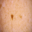

In [9]:
img=Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/ISIC_0015719.jpg")
img=img.resize((32, 32))
img

Support Vector Machines are supervised learning models which are often used in classification, regression, and outlier detection. They are effective in high dimesnional spaces, and still effective in cases where the number of dimensions is greater than the number of samples. A subset of training points are used in the decision function, called support vectors, which is beneficial in terms of memory efficiency. The ability to use different kernel functions makes this model versatile. Common kernels are provided in Python packages, but it's also possible to specify custom-made kernels. 

In [10]:
train_csv[train_csv['target']==1]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...,...
32969,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1
33000,ISIC_9963177,IP_1165806,male,70.0,torso,melanoma,malignant,1
33014,ISIC_9967383,IP_7887363,male,60.0,upper extremity,melanoma,malignant,1
33050,ISIC_9978107,IP_2860540,male,65.0,lower extremity,melanoma,malignant,1


In [11]:
malignant_df=train_csv[train_csv['target']==1][:500]
benign_df=train_csv[train_csv['target']==0][:30000].sample(n=500)

malignant_df_dev=train_csv[train_csv['target']==1][500:]
benign_df_dev=train_csv[train_csv['target']==0][30000:30500].sample(n=len(malignant_df_dev))

train_labels_mal=malignant_df['target'].tolist()
image_names_mal=malignant_df['image_name'].tolist()
train_labels_ben=benign_df['target'].tolist()
image_names_ben=benign_df['image_name'].tolist()

dev_labels_mal=malignant_df_dev['target'].tolist()
dev_image_names_mal=malignant_df_dev['image_name'].tolist()
dev_labels_ben=benign_df_dev['target'].tolist()
dev_image_names_ben=benign_df_dev['image_name'].tolist()
train_labels=[1 for image in image_names_mal]+[0 for image in image_names_ben]
dev_labels=[1 for image in dev_image_names_mal]+[0 for image in dev_image_names_ben]

In the case of this dataset, when target==1, the image of the mole is a melanoma and when target==0, the image of the model is non-malignant.

###Initial SVM Model Using Sklearn

In [12]:
square_side_lengths=[64,32]

for square_side_length in square_side_lengths:
  train_data=[]
  train_labels=[]
  num_mal=0
  num_benign=0
  for image in image_names_mal:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
      im=array(im.resize((square_side_length, square_side_length)))
      train_data.append(im)
      train_labels.append(1)
      num_mal+=1
    except:
      pass

  for image in image_names_ben:
      try:
        im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image)) #"/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/{}.jpg"
        im=array(im.resize((square_side_length, square_side_length)))
        train_data.append(im)
        train_labels.append(0)
        num_benign+=1
      except:
        pass


  dev_data=[]
  dev_labels=[]
  num_mal=0
  num_benign=0
  for image in dev_image_names_mal:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
      im=array(im.resize((square_side_length, square_side_length)))
      dev_data.append(im)
      dev_labels.append(1)
      num_mal+=1
    except:
      pass

  for image in dev_image_names_ben:
      try:
        im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
        im=array(im.resize((square_side_length, square_side_length)))
        dev_data.append(im)
        dev_labels.append(0)
        num_benign+=1
      except:
        pass
    
  target_names=[str(x) for x in list(np.unique(dev_labels))]

  train_data=array(train_data)
  dev_data=array(dev_data)
  X_train = train_data.reshape(train_data.shape[0], square_side_length, square_side_length, 3)
  X_dev = dev_data.reshape(dev_data.shape[0], square_side_length, square_side_length, 3)
  X_train = X_train.astype('float32')
  X_dev = X_dev.astype('float32')

  X_train /= 255
  X_dev /= 255

  Y_train = np_utils.to_categorical(train_labels, 2)
  Y_dev = np_utils.to_categorical(dev_labels, 2)

  X_train_svm=[]
  for i in X_train:
    nsamples, nx, ny = i.shape
    d2_train_dataset = i.reshape((nsamples*nx*ny))
    X_train_svm.append(d2_train_dataset)

  X_dev_svm=[]
  for i in X_dev:
    nsamples, nx, ny = i.shape
    d2_train_dataset = i.reshape((nsamples*nx*ny))
    X_dev_svm.append(d2_train_dataset)

  for kern in ('rbf','linear', 'poly'):
    svm = make_pipeline(StandardScaler(), SVC(kernel=kern,gamma='auto'))
    svm.fit(X_train_svm, train_labels)
    prediction_svm=svm.predict(X_dev_svm) #predicting with dev_data
    print("Square Side Length={}, Kernel={}".format(square_side_length,kern))
    print(classification_report(dev_labels, prediction_svm, target_names=target_names)) #printing classification report to get key result
    fpr, tpr, thresholds = metrics.roc_curve(dev_labels, prediction_svm, pos_label=1)
    print("AUC",metrics.auc(fpr, tpr))

Square Side Length=64, Kernel=rbf
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        84
           1       0.71      0.86      0.78        84

    accuracy                           0.76       168
   macro avg       0.77      0.76      0.75       168
weighted avg       0.77      0.76      0.75       168

AUC 0.7559523809523809
Square Side Length=64, Kernel=linear
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        84
           1       0.73      0.69      0.71        84

    accuracy                           0.72       168
   macro avg       0.72      0.72      0.72       168
weighted avg       0.72      0.72      0.72       168

AUC 0.7202380952380952
Square Side Length=64, Kernel=poly
              precision    recall  f1-score   support

           0       0.79      0.60      0.68        84
           1       0.68      0.85      0.75        84

    accuracy                  

Increasing the square side length of images reduced accuracy. Smaller images will be used moving forward.

### Tensorflow Model with Reduced Dataset

In [13]:
#train_data=array(train_data_list)
#dev_data=array(dev_data_list)
#X_train = train_data.reshape(train_data.shape[0], 32, 32, 3)
#X_dev = dev_data.reshape(dev_data.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_dev = X_dev.astype('float32')

X_train /= 255
X_dev /= 255

Y_train = np_utils.to_categorical(train_labels, 2)
Y_dev = np_utils.to_categorical(dev_labels, 2)

X_train_svm=[]
for i in X_train:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_train_svm.append(d2_train_dataset)

X_dev_svm=[]
for i in X_dev:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_dev_svm.append(d2_train_dataset)

target_names=[str(x) for x in list(np.unique(dev_labels))]

#https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/contrib/learn/python/learn/estimators/svm.py
X = np.array(X_train_svm)
Y = np.array(train_labels)

X_dev=np.array(X_dev_svm)
Y_dev=np.array(dev_labels)

example_id = np.array(['%d' % i for i in range(len(Y))])
example_id_dev = np.array(['%d' % i for i in range(len(Y_dev))])

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id},
    y=Y,
    num_epochs=None,
    shuffle=True)

dev_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X_dev, example_id_column_name: example_id_dev},
    y=Y_dev,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=49152),),
    l2_regularization=1)

svm.fit(input_fn=train_input_fn, steps=100)
svm_metrics = svm.evaluate(input_fn=dev_input_fn, steps=100)
#auc=metrics=[tf.keras.metrics.AUC()]
#svm_predictions=[x for x in svm.predict_classes(input_fn=dev_input_fn)]

#fpr, tpr, thresholds = metrics.roc_curve(dev_labels, svm_predictions, pos_label=1)
#print("AUC",metrics.auc(fpr, tpr))
#print("Loss", svm_metrics['loss'], "\nAccuracy", svm_metrics['accuracy'])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please switch to tf.contrib.estimator.*_head.


Instructions for updating:
Please switch to tf.contrib.estimator.*_head.


Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*


Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f59963e8400>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpv9yr_qmy', '_session_creation_timeout_secs': 7200}


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f59963e8400>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpv9yr_qmy', '_session_creation_timeout_secs': 7200}


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpv9yr_qmy/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpv9yr_qmy/model.ckpt.


INFO:tensorflow:loss = 0.93844235, step = 1


INFO:tensorflow:loss = 0.93844235, step = 1


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpv9yr_qmy/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpv9yr_qmy/model.ckpt.


INFO:tensorflow:Loss for final step: 0.9013876.


INFO:tensorflow:Loss for final step: 0.9013876.


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Starting evaluation at 2020-08-02T18:28:51Z


INFO:tensorflow:Starting evaluation at 2020-08-02T18:28:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpv9yr_qmy/model.ckpt-100


INFO:tensorflow:Restoring parameters from /tmp/tmpv9yr_qmy/model.ckpt-100


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-08-02-18:28:52


INFO:tensorflow:Finished evaluation at 2020-08-02-18:28:52


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.5722656, global_step = 100, loss = 0.876158


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.5722656, global_step = 100, loss = 0.876158


In [14]:
#malignant_df=train_csv[train_csv['target']==1][:500]
benign_df=train_csv[train_csv['target']==0][:30000]#.sample(n=500)

#malignant_df_dev=train_csv[train_csv['target']==1][500:]
benign_df_dev=train_csv[train_csv['target']==0][30000:30500]#.sample(n=len(malignant_df_dev))

#train_labels_mal=malignant_df['target'].tolist()
#image_names_mal=malignant_df['image_name'].tolist()
train_labels_ben=benign_df['target'].tolist()
image_names_ben=benign_df['image_name'].tolist()

#dev_labels_mal=malignant_df_dev['target'].tolist()
#dev_image_names_mal=malignant_df_dev['image_name'].tolist()
dev_labels_ben=benign_df_dev['target'].tolist()
dev_image_names_ben=benign_df_dev['image_name'].tolist()
train_labels=[1 for image in image_names_mal]+[0 for image in image_names_ben]
dev_labels=[1 for image in dev_image_names_mal]+[0 for image in dev_image_names_ben]

In [15]:
'''train_data=[]

for image in image_names_mal:
  try:
    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
    im=array(im.resize((32, 32)))
    train_data.append(im)
  except:
    pass


 
for image in image_names_ben:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image)) #"/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/{}.jpg"
      im=array(im.resize((32, 32)))
      train_data.append(im)
    except:
      pass

train_df=pd.DataFrame(columns=['image #']+[str(x+1) for x in range(32)])
for i in range(len(train_data)):
  img=train_data[i]
  for j in range(len(img)):
    train_df.loc[i,'image #']=i
    train_df.loc[i,str(j+1)]=img[j].reshape(32*3)

train_df.to_csv("train_data.csv")'''

'train_data=[]\n\nfor image in image_names_mal:\n  try:\n    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))\n    im=array(im.resize((32, 32)))\n    train_data.append(im)\n  except:\n    pass\n\n\n \nfor image in image_names_ben:\n    try:\n      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image)) #"/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/{}.jpg"\n      im=array(im.resize((32, 32)))\n      train_data.append(im)\n    except:\n      pass\n\ntrain_df=pd.DataFrame(columns=[\'image #\']+[str(x+1) for x in range(32)])\nfor i in range(len(train_data)):\n  img=train_data[i]\n  for j in range(len(img)):\n    train_df.loc[i,\'image #\']=i\n    train_df.loc[i,str(j+1)]=img[j].reshape(32*3)\n\ntrain_df.to_csv("train_data.csv")'

In [16]:
'''dev_data=[]


for image in dev_image_names_mal:
  try:
    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
    im=array(im.resize((32, 32)))
    dev_data.append(im)
  except:
    pass

for image in dev_image_names_ben:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
      im=array(im.resize((32, 32)))
      dev_data.append(im)
    except:
      pass


dev_df=pd.DataFrame(columns=['image #']+[str(x+1) for x in range(32)])
for i in range(len(dev_data)):
  img=train_data[i]
  for j in range(len(img)):
    dev_df.loc[i,'image #']=i
    dev_df.loc[i,str(j+1)]=img[j].reshape(32*3)

dev_df.to_csv("dev_data.csv")
#pd.DataFrame(list(zip(dev_data, dev_labels)), columns =['dev_data', 'dev_labels']).to_csv("dev_data.csv")'''

'dev_data=[]\n\n\nfor image in dev_image_names_mal:\n  try:\n    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))\n    im=array(im.resize((32, 32)))\n    dev_data.append(im)\n  except:\n    pass\n\nfor image in dev_image_names_ben:\n    try:\n      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))\n      im=array(im.resize((32, 32)))\n      dev_data.append(im)\n    except:\n      pass\n\n\ndev_df=pd.DataFrame(columns=[\'image #\']+[str(x+1) for x in range(32)])\nfor i in range(len(dev_data)):\n  img=train_data[i]\n  for j in range(len(img)):\n    dev_df.loc[i,\'image #\']=i\n    dev_df.loc[i,str(j+1)]=img[j].reshape(32*3)\n\ndev_df.to_csv("dev_data.csv")\n#pd.DataFrame(list(zip(dev_data, dev_labels)), columns =[\'dev_data\', \'dev_labels\']).to_csv("dev_data.csv")'

In [17]:
train_data=pd.read_csv("train_data.csv")
dev_data=pd.read_csv("dev_data.csv")

In [18]:
train_data_list=[]
dev_data_list=[]

def update_pixels(pixel_n,index_n):
  new_array=train_data[pixel_n][index_n].replace("[","").replace("]","").replace("\n","").split(" ")
  new_array[:] = [x for x in new_array if x != '']
  return array([int(x) for x in new_array]).reshape(32,3)

for index, row in train_data.iterrows():
    picture_list=[]
    for i in range(32): 
      pixel_index=str(i+1)
      new_pixels=update_pixels(pixel_index,index)
      picture_list.append(new_pixels)
    picture_list=array(picture_list)
    train_data_list.append(picture_list)

for index, row in dev_data.iterrows():
    picture_list=[]
    for i in range(32): 
      pixel_index=str(i+1)
      new_pixels=update_pixels(pixel_index,index)
      picture_list.append(new_pixels)
    picture_list=array(picture_list)
    dev_data_list.append(picture_list)

In [19]:
train_data=array(train_data_list)
dev_data=array(dev_data_list)
X_train = train_data.reshape(train_data.shape[0], 32, 32, 3)
X_dev = dev_data.reshape(dev_data.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_dev = X_dev.astype('float32')

X_train /= 255
X_dev /= 255

Y_train = np_utils.to_categorical(train_labels, 2)
Y_dev = np_utils.to_categorical(dev_labels, 2)

X_train_svm=[]
for i in X_train:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_train_svm.append(d2_train_dataset)

X_dev_svm=[]
for i in X_dev:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_dev_svm.append(d2_train_dataset)

target_names=[str(x) for x in list(np.unique(dev_labels))]

### Base Model Using Tensorflow, Large Dataset

In [20]:
#https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/contrib/learn/python/learn/estimators/svm.py
X = np.array(X_train_svm)
Y = np.array(train_labels)

X_dev=np.array(X_dev_svm)
Y_dev=np.array(dev_labels)

example_id = np.array(['%d' % i for i in range(len(Y))])
example_id_dev = np.array(['%d' % i for i in range(len(Y_dev))])

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id},
    y=Y,
    num_epochs=None,
    shuffle=True)

dev_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X_dev, example_id_column_name: example_id_dev},
    y=Y_dev,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=49152),),
    l2_regularization=1)

svm.fit(input_fn=train_input_fn, steps=100)
svm_metrics = svm.evaluate(input_fn=dev_input_fn, steps=100)
#auc=metrics=[tf.keras.metrics.AUC()]
#svm_predictions=[x for x in svm.predict_classes(input_fn=dev_input_fn)]

#fpr, tpr, thresholds = metrics.roc_curve(dev_labels, svm_predictions, pos_label=1)
#print("AUC",metrics.auc(fpr, tpr))
print("Loss", svm_metrics['loss'], "\nAccuracy", svm_metrics['accuracy'])

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f598df27e10>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpylpwtah5', '_session_creation_timeout_secs': 7200}


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f598df27e10>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpylpwtah5', '_session_creation_timeout_secs': 7200}


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpylpwtah5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpylpwtah5/model.ckpt.


INFO:tensorflow:loss = 1.0, step = 1


INFO:tensorflow:loss = 1.0, step = 1


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpylpwtah5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpylpwtah5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0.


INFO:tensorflow:Loss for final step: 0.0.


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Starting evaluation at 2020-08-02T18:30:13Z


INFO:tensorflow:Starting evaluation at 2020-08-02T18:30:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpylpwtah5/model.ckpt-100


INFO:tensorflow:Restoring parameters from /tmp/tmpylpwtah5/model.ckpt-100


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-08-02-18:30:14


INFO:tensorflow:Finished evaluation at 2020-08-02-18:30:14


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.85484374, global_step = 100, loss = 0.6049458


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.85484374, global_step = 100, loss = 0.6049458


Loss 0.6049458 
Accuracy 0.85484374


### Tensorflow Model with Weights, Large Dataset

In [21]:
num_benign_samples=30000
num_malignant_samples=500
weights=np.array([num_benign_samples/num_malignant_samples for x in range(500)]+[1 for x in range(num_benign_samples)]).astype(np.float32)
dev_weights=np.array([1 for i in range(len(Y_dev))]).astype(np.float32)

In [22]:
len(dev_weights)

584

In [23]:
#https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/contrib/learn/python/learn/estimators/svm.py
weight_column_name1="weight"

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id,"weight":weights},
    y=Y,
    num_epochs=None,
    shuffle=True)

dev_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X_dev, example_id_column_name: example_id_dev,"weight":dev_weights},
    y=Y_dev,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    weight_column_name="weight",
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=49152),),
    l2_regularization=1)

svm.fit(input_fn=train_input_fn, steps=100)

svm_metrics = svm.evaluate(input_fn=dev_input_fn, steps=100)
#auc=metrics=[tf.keras.metrics.AUC()]
#svm_predictions=[i for i in svm.predict_classes(input_fn=dev_input_fn)]

#fpr, tpr, thresholds = metrics.roc_curve(dev_labels, svm_predictions, pos_label=1)
#print("AUC",metrics.auc(fpr, tpr))
print("Loss", svm_metrics['loss'], "\nAccuracy", svm_metrics['accuracy'])

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f598df27160>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpglcb6z0x', '_session_creation_timeout_secs': 7200}


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f598df27160>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpglcb6z0x', '_session_creation_timeout_secs': 7200}


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpglcb6z0x/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpglcb6z0x/model.ckpt.


INFO:tensorflow:loss = 1.0, step = 1


INFO:tensorflow:loss = 1.0, step = 1


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpglcb6z0x/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpglcb6z0x/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0014205705.


INFO:tensorflow:Loss for final step: 0.0014205705.


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Starting evaluation at 2020-08-02T18:30:15Z


INFO:tensorflow:Starting evaluation at 2020-08-02T18:30:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpglcb6z0x/model.ckpt-100


INFO:tensorflow:Restoring parameters from /tmp/tmpglcb6z0x/model.ckpt-100


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-08-02-18:30:16


INFO:tensorflow:Finished evaluation at 2020-08-02-18:30:16


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.8549219, global_step = 100, loss = 0.44328803


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.8549219, global_step = 100, loss = 0.44328803


Loss 0.44328803 
Accuracy 0.8549219


### Base Models Using SVM in Scikit Learn with Differing Kernels

Instead of using an even number of examples from each of the benign and malignant datasets, weights will be used in the following models -- giving more weights to the malignant examples.

In [24]:
for weight in (1,30,60):
  for kern in ('rbf','linear', 'poly'):
    weights=[weight for x in range(num_malignant_samples)]+[1 for x in range(num_benign_samples)]
    svm =  Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel=kern,gamma='auto'))])
    svm.fit(X_train_svm, train_labels, **{'svc__sample_weight': weights})

    prediction_svm=svm.predict(X_dev_svm) #predicting with dev_data
    print('Weights={}, Kernel={}'.format(weight, kern))
    print(classification_report(dev_labels, prediction_svm, target_names=target_names))

    fpr, tpr, thresholds = metrics.roc_curve(dev_labels, prediction_svm, pos_label=1)
    print("AUC",metrics.auc(fpr, tpr))

Weights=1, Kernel=rbf
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.84       584
   macro avg       0.43      0.49      0.46       584
weighted avg       0.73      0.84      0.78       584

AUC 0.493
Weights=1, Kernel=linear
              precision    recall  f1-score   support

           0       0.88      0.46      0.60       500
           1       0.16      0.62      0.25        84

    accuracy                           0.48       584
   macro avg       0.52      0.54      0.43       584
weighted avg       0.77      0.48      0.55       584

AUC 0.5375238095238095
Weights=1, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       500
           1       0.14      0.14      0.14        84

    accuracy                           0.75       584
   macro avg       0.50  

###SVM with PCA and Weights

In [25]:

from sklearn.decomposition import PCA

for pca_n in (1,3,5,7,9):
  pca = PCA(n_components=pca_n) #PCA with 3 dimensions
  pca.fit(X_train_svm) 
  pca_train = pca.transform(X_train_svm) #tra nsform train data to 5 dimensions
  pca_test = pca.transform(X_dev_svm) 

  #weight=60
  for weight in (1,30,60):
    for kern in ('rbf','linear', 'poly'):
      weights=[weight for x in range(num_malignant_samples)]+[1 for x in range(num_benign_samples)]
      svm =  Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel=kern,gamma='auto'))])
      svm.fit(pca_train, train_labels, **{'svc__sample_weight': weights})

      prediction_svm=svm.predict(pca_test) #predicting with dev_data
      print('Weights={}, Kernel={}'.format(weight, kern))
      print(classification_report(dev_labels, prediction_svm, target_names=target_names))

      fpr, tpr, thresholds = metrics.roc_curve(dev_labels, prediction_svm, pos_label=1)
      print("AUC",metrics.auc(fpr, tpr))

Weights=1, Kernel=rbf
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=linear
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=30, Kernel=rbf
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       500
           1       0.10      0.08      0.09        84

    accuracy                           0.76       584
   macro avg       0.48      0.48      0.48       584
weighted avg       0.74      0.76      0.75       584

AUC 0.47866666666666663
Weights=30, Kernel=linear
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=30, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       500
           1       0.17      0.05      0.07        84

    accuracy                           0.83       584
   macro avg       0.52      0.50      0.49       584
weighted avg       0.76      0.83      0.79       584

AUC 0.5048095238095238
Weights=60, Kernel=rbf
              precision    recall  f1-score   support

           0       0.86      0.22      0.36       500
           1       0.15      0.79      0.25        84

    accuracy                           0.30       584
   macro avg       0.50      0.50      0.30       584
weighted avg       0.76      0.30      0.34       584

AUC 0.5048571428571429
Weights=60, Kernel=linear
              precision    recall  f1-score   support

           0       0.84      0.34      0.48       500
           1       0.14      0.63      0.23        84

    accuracy                           0.38       584
   macro 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=linear
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=30, Kernel=rbf
              precision    recall  f1-score   support

           0       0.86      0.50      0.63       500
           1       0.14      0.50      0.22        84

    accuracy                           0.50       584
   macro avg       0.50      0.50      0.43       584
weighted avg       0.75      0.50      0.57       584

AUC 0.501
Weights=30, Kernel=linear
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       500
           1       0.14      0.18      0.15        84

    accuracy                           0.72       584
   macro avg       0.50      0.49      0.49       584
weighted avg       0.75      0.72      0.73       584

AUC 0.49428571428571433
Weights=30, Kernel=poly
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       500
           1       0.12      0.10      0.11        84

    accuracy                           0.77       584
   macro avg       0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=linear
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=30, Kernel=rbf
              precision    recall  f1-score   support

           0       0.90      0.35      0.50       500
           1       0.16      0.76      0.27        84

    accuracy                           0.41       584
   macro avg       0.53      0.56      0.39       584
weighted avg       0.79      0.41      0.47       584

AUC 0.555952380952381
Weights=30, Kernel=linear
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       500
           1       0.13      0.25      0.17        84

    accuracy                           0.66       584
   macro avg       0.49      0.49      0.48       584
weighted avg       0.75      0.66      0.70       584

AUC 0.489
Weights=30, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       500
           1       0.16      0.25      0.19        84

    accuracy                           0.70       584
   macro avg       0.51

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=30, Kernel=rbf
              precision    recall  f1-score   support

           0       0.94      0.29      0.44       500
           1       0.17      0.88      0.29        84

    accuracy                           0.38       584
   macro avg       0.55      0.59      0.37       584
weighted avg       0.83      0.38      0.42       584

AUC 0.5854761904761905
Weights=30, Kernel=linear
              precision    recall  f1-score   support

           0       0.86      0.64      0.73       500
           1       0.14      0.36      0.20        84

    accuracy                           0.60       584
   macro avg       0.50      0.50      0.47       584
weighted avg       0.75      0.60      0.66       584

AUC 0.4985714285714286
Weights=30, Kernel=poly
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       500
           1       0.16      0.38      0.23        84

    accuracy                           0.63       584
   macro 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=1, Kernel=poly
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weights=30, Kernel=rbf
              precision    recall  f1-score   support

           0       0.96      0.23      0.38       500
           1       0.17      0.94      0.29        84

    accuracy                           0.34       584
   macro avg       0.57      0.59      0.33       584
weighted avg       0.85      0.34      0.36       584

AUC 0.5872380952380952
Weights=30, Kernel=linear
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       500
           1       0.16      0.44      0.24        84

    accuracy                           0.59       584
   macro avg       0.51      0.53      0.48       584
weighted avg       0.77      0.59      0.65       584

AUC 0.5272380952380952
Weights=30, Kernel=poly
              precision    recall  f1-score   support

           0       0.85      0.57      0.69       500
           1       0.14      0.40      0.21        84

    accuracy                           0.55       584
   macro 

Looking at the results for the different SVM kernels, it appears rbf or poly will work best. Increasing the weights appeared to increase the AUC measure. The sklearn SVM models do not work as well as the tensor flow model. I will work on a more custom tensor flow model soon.